<a href="https://colab.research.google.com/github/pranshudatascience/Lung-and-Colon-Cancer-Histopathological-Images-dataset/blob/main/Lung_and_Colon_Cancer_Histopathological_Image_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

# **Uploading Data via Kaggle Api**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"datasciencepranshu","key":"f206fef76574e388b3dba86a1861be62"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.75G/1.76G [01:01<00:00, 57.9MB/s]
100% 1.76G/1.76G [01:01<00:00, 30.7MB/s]


In [5]:
from zipfile import ZipFile
file_name = "lung-and-colon-cancer-histopathological-images.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
IMAGE_SIZE = [224, 224]

In [6]:
#Give dataset path
train_path = '/content/lung_colon_image_set/lung_image_sets'
#test_path = '/content/validation/validation'

In [7]:
folders = glob('/content/lung_colon_image_set/lung_image_sets/*')
len(folders)

5

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **Designing Our Model**

In [9]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

234553344/234545216 [==============================] - 3s 0us/step


In [10]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=5, activation='softmax')(x)
model = Model(ResNet_model.input, output)


model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

# **Image Augmentation**

In [12]:
# Use the Image Data Generator to import the images from the dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)  # val 20%

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
#no flip and zoom for test dataset

In [13]:
# Make sure you provide the same target size as initialied for the image size

training_set = train_datagen.flow_from_directory('/content/lung_colon_image_set/lung_image_sets',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset = 'training')

Found 20000 images belonging to 5 classes.


In [14]:
test_set = test_datagen.flow_from_directory('/content/lung_colon_image_set/lung_image_sets',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset = 'validation')

Found 5000 images belonging to 5 classes.


# **Training Our Model**

In [16]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
625/625 [==============================] - 571s 913ms/step - loss: 0.0651 - accuracy: 0.9783 - val_loss: 0.0705 - val_accuracy: 0.9742
Epoch 2/10
625/625 [==============================] - 575s 919ms/step - loss: 0.0680 - accuracy: 0.9793 - val_loss: 0.0355 - val_accuracy: 0.9864
Epoch 3/10
625/625 [==============================] - 578s 924ms/step - loss: 0.0590 - accuracy: 0.9827 - val_loss: 0.0394 - val_accuracy: 0.9882
Epoch 4/10
625/625 [==============================] - 577s 923ms/step - loss: 0.0497 - accuracy: 0.9834 - val_loss: 0.0216 - val_accuracy: 0.9916
Epoch 5/10
625/625 [==============================] - 569s 910ms/step - loss: 0.0468 - accuracy: 0.9855 - val_loss: 0.0186 - val_accuracy: 0.9928
Epoch 6/10
625/625 [==============================] - 567s 908ms/step - loss: 0.0515 - accuracy: 0.9844 - val_loss: 0.0740 - val_accuracy: 0.9740
Epoch 7/10
625/625 [==============================] - 569s 910ms/step - loss: 0.0406 - accuracy: 0.9868 - val_loss: 0.0531 -

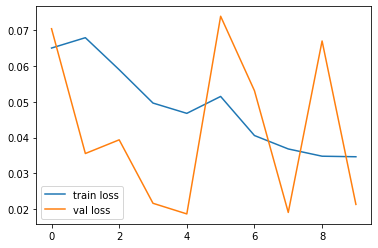

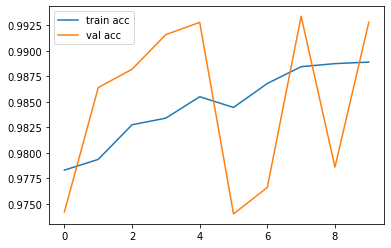

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
from tensorflow.keras.models import load_model

model.save('modellungcolon.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# **Making Predictions**

In [19]:
y_pred = model.predict(test_set)

In [20]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([3, 4, 3, ..., 1, 3, 3])

# **Make Predictions**

In [24]:
classes = ["Colon adenocarcinoma","Colon benign tissue", "Lung adenocarcinoma" , "Lung benign tissue" , "Lung squamous cell carcinoma"]

In [25]:
def predict_image(img):
    plt.figure(figsize=(40,8))
    print()
    print('----------------------------Lung and Colon Cancer Histopathological Images--------------------------------')
    print()
    print('------------------------------------THE Given Image is----------------------------------------------------')
    print()
    x=image.img_to_array(img)
    x=x/255
    plt.imshow(img)
    x=np.expand_dims(x,axis=0)
    #img_data=preprocess_input(x)

    print(classes[np.argmax(model.predict(x))])


----------------------------Lung and Colon Cancer Histopathological Images--------------------------------

------------------------------------THE Given Image is----------------------------------------------------

Colon benign tissue


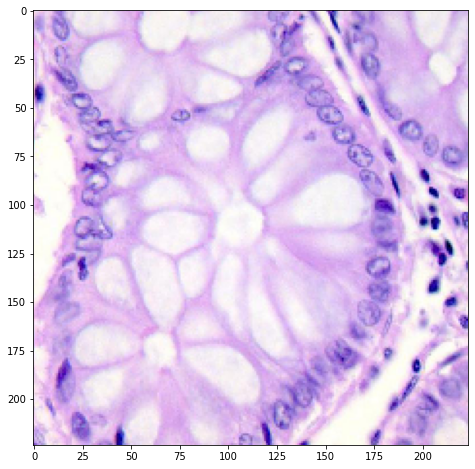

In [26]:
im=image.load_img('/content/lung_colon_image_set/lung_image_sets/colon_n/colonn1004.jpeg',target_size=(224,224))
predict_image(im)


----------------------------Lung and Colon Cancer Histopathological Images--------------------------------

------------------------------------THE Given Image is----------------------------------------------------

Lung adenocarcinoma


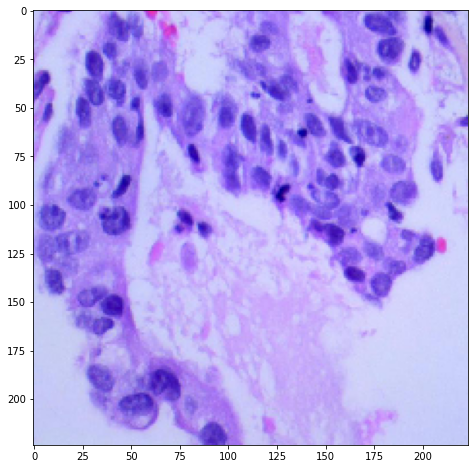

In [27]:
im2=image.load_img('/content/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1002.jpeg',target_size=(224,224))
predict_image(im2)


----------------------------Lung and Colon Cancer Histopathological Images--------------------------------

------------------------------------THE Given Image is----------------------------------------------------

Lung benign tissue


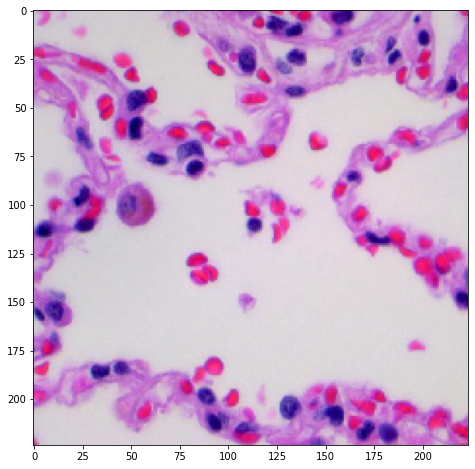

In [28]:
im3=image.load_img('/content/lung_colon_image_set/lung_image_sets/lung_n/lungn1005.jpeg',target_size=(224,224))
predict_image(im3)


----------------------------Lung and Colon Cancer Histopathological Images--------------------------------

------------------------------------THE Given Image is----------------------------------------------------

Colon adenocarcinoma


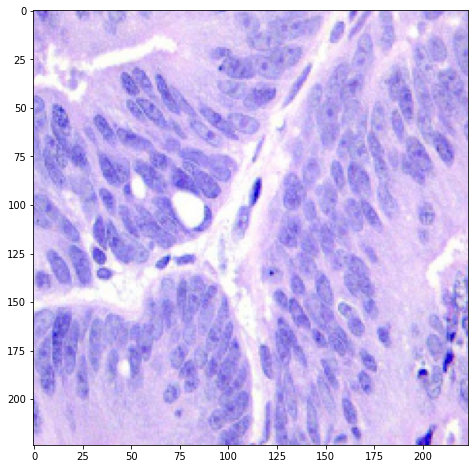

In [29]:
im4=image.load_img('/content/lung_colon_image_set/lung_image_sets/colon_aca/colonca1008.jpeg',target_size=(224,224))
predict_image(im4)


----------------------------Lung and Colon Cancer Histopathological Images--------------------------------

------------------------------------THE Given Image is----------------------------------------------------

Colon adenocarcinoma


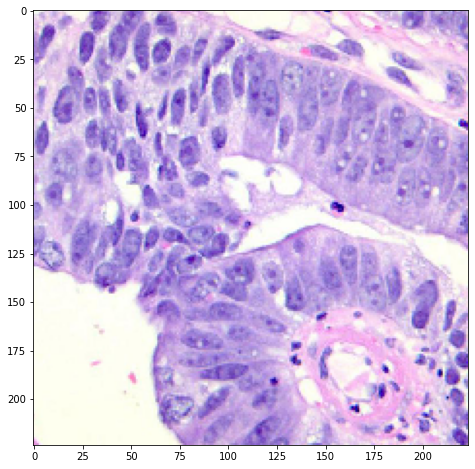

In [30]:
im5=image.load_img('/content/lung_colon_image_set/lung_image_sets/colon_aca/colonca1002.jpeg',target_size=(224,224))
predict_image(im5)